In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Softmax function at the output layer?
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [2]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [3]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy

In [2]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [3]:
def myMSE(pred,true):
    return ((pred-true)**2).mean()

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def kfold_maker(X,Y,k): #X,Y-> unshuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/k))
#     print(div)
    
    if k == 1:
        return X,Y
    cnt1 = 0
    cnt2 = div
    Xfolds = []
    Yfolds = []
    for i in range(k-1):
        
        Xfolds.append(X[cnt1:cnt2,:])
        Yfolds.append(Y[cnt1:cnt2,:])
        
        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xfolds.append(X[cnt1:,:])
    Yfolds.append(Y[cnt1:,:])

    return Xfolds,Yfolds

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [4]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output = nn. Softmax(dim=1)(net_output)
        return output,net_output

In [5]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [6]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [7]:
Xnum_train,Xnum_test,Ynum_train,Ynum_test = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("X test: ", Xnum_test.shape)
print("Y train: ", Ynum_train.shape)
print("Y test: ", Ynum_test.shape)
Y_binary_train_ = Ynum_train[:,0:-1]
Y_binary_test_ = Ynum_test[:,0:-1]

Ynum_train = Ynum_train[:,-1]
Ynum_test = Ynum_test[:,-1]

X train:  (1962, 12)
X test:  (841, 12)
Y train:  (1962, 4)
Y test:  (841, 4)


In [8]:
xdata_sc = StandardScaler()
Xnum_train = xdata_sc.fit_transform(Xnum_train)
Xnum_test = xdata_sc.transform(Xnum_test)

X_train_ = torch.tensor(Xnum_train.astype(np.float32))
Y_train_ = torch.tensor(Ynum_train,dtype=torch.long)
Y_binary_train_ = torch.tensor(Y_binary_train_.astype(np.float32))

X_test_ = torch.tensor(Xnum_test.astype(np.float32))
Y_test_ = torch.tensor(Ynum_test,dtype=torch.long)
Y_binary_test_ = torch.tensor(Y_binary_test_.astype(np.float32))

In [9]:
def mymodel(X_train_unshuff,X_test,Y_train_unshuff,Y_binary_train_unshuff,Y_test,Y_binary_test,learning_rate,momentum):    
    
    model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,momentum = momentum)
    
    num_epochs = 0 #Keeps track of the number of epochs 
    losses_train = [] #Stores training losses at each epoch
    losses_test = [] #Stores testing losses at each epoch
    
    accuracy_train = []
    accuracy_test = []

    num_batches = 1 #Number of training batches the training dataset is divided into
    tol = 8e-3 #when the training should stop
    error = 100 
    max_epochs = 500
    
    while (error > tol) and (num_epochs < max_epochs):

        num_epochs += 1
#         print("==="*5,"Epoch",num_epochs,"==="*5)

        X_train,Y_train,Y_binary_train = data_shuffler(X_train_unshuff,Y_train_unshuff,Y_binary_train_unshuff)
        Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        for iteration in range(num_batches): #for each batch...

            if num_batches == 1:
                X_train_batch = Xbatches
                Y_train_batch = Ybatches
                Y_train_binary_batch = YBinaryBatches

            else:     

                X_train_batch = Xbatches[iteration]
                Y_train_batch = Ybatches[iteration]
                Y_train_binary_batch = YBinaryBatches[iteration]

            
            #Forward pass
            ypred_train,output_net = model(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

            #Compute loss
            loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

            #Backward pass
            loss_train.backward()
#             print(f"===== Batch no. {iteration + 1}=====")
#             print(f"\n Batch Pred: \n{ypred_train} \n Batch Target:\n {Y_train_binary_batch}")
#             print("\n Batch Training Loss: ",loss_train)

            #Update weights
            optimizer.step()
            optimizer.zero_grad()

        #At the end of each epoch...
        with torch.no_grad():

            #Forward pass using entire dataset
            ypred_train_epoch,output_net_train_epoch = model(X_train)
            ypred_test_epoch,output_net_test_epoch = model(X_test)

            loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
            losses_train.append(loss_train_epoch)

            loss_test_epoch = criterion(output_net_test_epoch,Y_test).sum()/(n_classes*len(Y_test))
            losses_test.append(loss_test_epoch)

            #Accuracy Calculation
            Ypred_train_epoch = convert(ypred_train_epoch)
            Ypred_test_epoch = convert(ypred_test_epoch)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_epoch, Y_binary_train, Ypred_test_epoch, Y_binary_test)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_epoch)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_epoch)*100))
            
            error = ((ypred_train_epoch - Y_binary_train)**2).mean()

#             print("==="*5,"Epoch Data","==="*5)
#             if (num_epochs) % 10 == 0:
#                 print(f"Epoch: {num_epochs}\n Training Pred: \n{ypred_train_epoch} \n Training Target: \n{Y_binary_train} ")
#                 print(f"\n Testing Pred: \n{ypred_test_epoch} \n Testing Target: \n{Y_binary_test} ")
#                 print("Training Loss: ",loss_train_epoch)
#                 print("Testing Loss: ",loss_test_epoch)
#                 print("Accuracy Train:", 100-(cnt_train/len(Ypred_train_epoch)*100))
#                 print("Accuracy Test:", 100-(cnt_test/len(Ypred_test_epoch)*100))
#                 print("Error:", error)
#                 print("==="*10)
                
    losses_train = torch.tensor(losses_train)
    losses_test = torch.tensor(losses_test)
    
    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)

#     print("==="*10)
#     print("==="*10)
#     print("TRAINING COMPLETE")
#     print("Final Training Loss: ",loss_train_epoch)
#     print("Final Training Loss: ",loss_test_epoch)
#     print("Final Error:", error)
#     print("Total number of epochs:",num_epochs+ 1)
#     print("==="*10)
#     print("==="*10)
    
    return {"LossTrain":losses_train,
            "LossTest":losses_test,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
           "NumEpochs": num_epochs}

In [12]:
num_runs = 30

results1 = []
results2 = []
results3 = []
results4 = []
results5 = []

for u in range(num_runs):
    model1 = mymodel(X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 1.7,momentum = 0.2)
    model2 = mymodel(X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 1.3,momentum = 0.5)
    model3 = mymodel(X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 1.1,momentum = 0.2)
    model4 = mymodel(X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 2.1,momentum = 0.4)
    model5 = mymodel(X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 2.1,momentum = 0.6)

    print(u+1)

    results1.append(model1)
    results2.append(model2)
    results3.append(model3)
    results4.append(model4)
    results5.append(model5)

1
2


KeyboardInterrupt: 

In [14]:
losses1_train = []
losses2_train = []
losses3_train = []

losses1_test = []
losses2_test = []
losses3_test = []

acc1_train = []
acc2_train = []
acc3_train = []

acc1_test = []
acc2_test = []
acc3_test = []

for u in range(30):
    losses1_train.append(results1[u]["LossTrain"][-1])
    losses2_train.append(results2[u]["LossTrain"][-1])
    losses3_train.append(results3[u]["LossTrain"][-1])
    
    losses1_test.append(results1[u]["LossTest"][-1])
    losses2_test.append(results2[u]["LossTest"][-1])
    losses3_test.append(results3[u]["LossTest"][-1])
    
    acc1_train.append(results1[u]["AccTrain"][-1])
    acc2_train.append(results2[u]["AccTrain"][-1])
    acc3_train.append(results3[u]["AccTrain"][-1])
    
    acc1_test.append(results1[u]["AccTest"][-1])
    acc2_test.append(results2[u]["AccTest"][-1])
    acc3_test.append(results3[u]["AccTest"][-1])
    
avg_train_loss1 = torch.tensor(losses1_train).mean()
avg_train_loss2 = torch.tensor(losses2_train).mean()
avg_train_loss3 = torch.tensor(losses3_train).mean()

avg_test_loss1 = torch.tensor(losses1_test).mean()
avg_test_loss2 = torch.tensor(losses2_test).mean()
avg_test_loss3 = torch.tensor(losses3_test).mean()

avg_train_acc1 = torch.tensor(acc1_train).mean()
avg_train_acc2 = torch.tensor(acc2_train).mean()
avg_train_acc3 = torch.tensor(acc3_train).mean()

avg_test_acc1 = torch.tensor(acc1_test).mean()
avg_test_acc2 = torch.tensor(acc2_test).mean()
avg_test_acc3 = torch.tensor(acc3_test).mean()

std_train_loss1 =torch.sqrt(torch.var(torch.tensor(losses1_train)))
std_train_loss2 =torch.sqrt(torch.var(torch.tensor(losses2_train)))
std_train_loss3 =torch.sqrt(torch.var(torch.tensor(losses3_train)))

std_test_loss1 =torch.sqrt(torch.var(torch.tensor(losses1_test)))
std_test_loss2 =torch.sqrt(torch.var(torch.tensor(losses2_test)))
std_test_loss3 =torch.sqrt(torch.var(torch.tensor(losses3_test)))

std_train_acc1 =torch.sqrt(torch.var(torch.tensor(acc1_train)))
std_train_acc2 =torch.sqrt(torch.var(torch.tensor(acc2_train)))
std_train_acc3 =torch.sqrt(torch.var(torch.tensor(acc3_train)))

std_test_acc1 =torch.sqrt(torch.var(torch.tensor(acc1_test)))
std_test_acc2 =torch.sqrt(torch.var(torch.tensor(acc2_test)))
std_test_acc3 =torch.sqrt(torch.var(torch.tensor(acc3_test)))

<IPython.core.display.Javascript object>


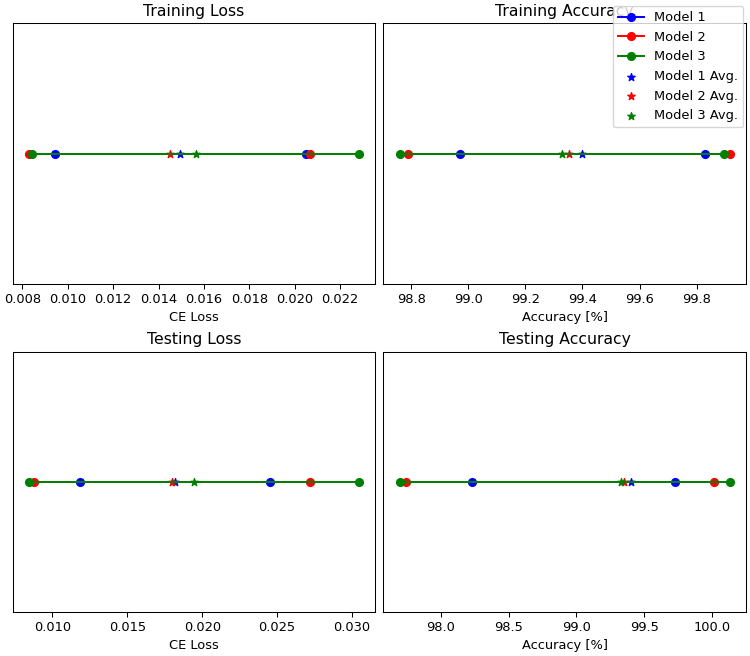

In [40]:
%matplotlib notebook
fig0, ax0 = plt.subplots(2,2,figsize = (8,7),layout = 'constrained')

ax0[0,0].plot([avg_train_loss1 - 2*std_train_loss1,avg_train_loss1 + 2*std_train_loss1],[0,0],marker = 'o',color='b',label = "Model 1")
ax0[0,0].plot([avg_train_loss2 - 2*std_train_loss2,avg_train_loss2 + 2*std_train_loss2],[0,0],marker = 'o',color='r',label = "Model 2")
ax0[0,0].plot([avg_train_loss3 - 2*std_train_loss3,avg_train_loss3 + 2*std_train_loss3],[0,0],marker = 'o',color='g',label = "Model 3")
ax0[0,0].set_title("Training Loss")
ax0[0,0].set_xlabel("CE Loss")
ax0[0,0].tick_params(left = False, right = False, labelleft = False,labelbottom = True, bottom = True)
ax0[0,0].scatter([avg_train_loss1],[0],marker = '*',color='b',label = 'Model 1 Avg.')
ax0[0,0].scatter([avg_train_loss2],[0],marker = '*',color='r',label = 'Model 2 Avg.')
ax0[0,0].scatter([avg_train_loss3],[0],marker = '*',color='g',label = 'Model 3 Avg.')

ax0[0,1].plot([avg_train_acc1 - 2*std_train_acc1,avg_train_acc1 + 2*std_train_acc1],[0,0],marker = 'o',color='b')
ax0[0,1].plot([avg_train_acc2 - 2*std_train_acc2,avg_train_acc2 + 2*std_train_acc2],[0,0],marker = 'o',color='r')
ax0[0,1].plot([avg_train_acc3 - 2*std_train_acc3,avg_train_acc3 + 2*std_train_acc3],[0,0],marker = 'o',color='g')
ax0[0,1].set_title("Training Accuracy")
ax0[0,1].set_xlabel("Accuracy [%]")
ax0[0,1].tick_params(left = False, right = False, labelleft = False,labelbottom = True, bottom = True)
ax0[0,1].scatter([avg_train_acc1],[0],marker = '*',color='b')
ax0[0,1].scatter([avg_train_acc2],[0],marker = '*',color='r')
ax0[0,1].scatter([avg_train_acc3],[0],marker = '*',color='g')


ax0[1,0].plot([avg_test_loss1 - 2*std_test_loss1,avg_test_loss1 + 2*std_test_loss1],[0,0],marker = 'o',color='b')
ax0[1,0].plot([avg_test_loss2 - 2*std_test_loss2,avg_test_loss2 + 2*std_test_loss2],[0,0],marker = 'o',color='r')
ax0[1,0].plot([avg_test_loss3 - 2*std_test_loss3,avg_test_loss3 + 2*std_test_loss3],[0,0],marker = 'o',color='g')
ax0[1,0].set_title("Testing Loss")
ax0[1,0].set_xlabel("CE Loss")
ax0[1,0].tick_params(left = False, right = False, labelleft = False,labelbottom = True, bottom = True)
ax0[1,0].scatter([avg_test_loss1],[0],marker = '*',color='b')
ax0[1,0].scatter([avg_test_loss2],[0],marker = '*',color='r')
ax0[1,0].scatter([avg_test_loss3],[0],marker = '*',color='g')



ax0[1,1].plot([avg_test_acc1 - 2*std_test_acc1,avg_test_acc1 + 2*std_test_acc1],[0,0],marker = 'o',color='b')
ax0[1,1].plot([avg_test_acc2 - 2*std_test_acc2,avg_test_acc2 + 2*std_test_acc2],[0,0],marker = 'o',color='r')
ax0[1,1].plot([avg_test_acc3 - 2*std_test_acc3,avg_test_acc3 + 2*std_test_acc3],[0,0],marker = 'o',color='g')
ax0[1,1].set_title("Testing Accuracy")
ax0[1,1].set_xlabel("Accuracy [%]")
ax0[1,1].tick_params(left = False, right = False, labelleft = False,labelbottom = True, bottom = True)
ax0[1,1].scatter([avg_train_acc1],[0],marker = '*',color='b')
ax0[1,1].scatter([avg_train_acc2],[0],marker = '*',color='r')
ax0[1,1].scatter([avg_train_acc3],[0],marker = '*',color='g')

fig0.legend()

In [41]:
plt.savefig("hyperparam",dpi = 200)